# **Part 1**

using the word2vec-google-news-300 pretrained model (which is 300-dimensional and trained on ~100 billion words from Google News)

Step-by-step plan:

- Load the pretrained word2vec model.

- Pick 5 arbitrary words.

- Get top 5 similar words for each.

- Do 2–3 vector arithmetic analogies like king - man + woman ≈ queen.

In [1]:
!pip install gensim

In [7]:
import gensim.downloader as api
wv_pretrained = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [8]:
words = ['computer', 'city', 'music', 'teacher', 'happy']
for word in words:
    print(f"Most similar to '{word}':")
    print(wv_pretrained.most_similar(word, topn=5))

Most similar to 'computer':
[('computers', 0.7979379892349243), ('laptop', 0.6640493273735046), ('laptop_computer', 0.6548868417739868), ('Computer', 0.647333562374115), ('com_puter', 0.6082080006599426)]
Most similar to 'city':
[('citys', 0.6803998947143555), ('mayor', 0.675115168094635), ('town', 0.6723739504814148), ('municipality', 0.6530812382698059), ('municipal', 0.6222546100616455)]
Most similar to 'music':
[('classical_music', 0.7197794318199158), ('jazz', 0.6834640502929688), ('Music', 0.6595720648765564), ('Without_Donny_Kirshner', 0.6416222453117371), ('songs', 0.6396344304084778)]
Most similar to 'teacher':
[('teachers', 0.7434303164482117), ('Teacher', 0.7094013690948486), ('guidance_counselor', 0.6960431933403015), ('elementary', 0.6790565252304077), ('PE_teacher', 0.6539358496665955)]
Most similar to 'happy':
[('glad', 0.7408890724182129), ('pleased', 0.6632170677185059), ('ecstatic', 0.6626912355422974), ('overjoyed', 0.6599286794662476), ('thrilled', 0.651404917240142

In [9]:
# king - man + woman ~ queen
print(wv_pretrained.most_similar(positive=['king', 'woman'], negative=['man'], topn=1))

# Example analogies
# France - Paris + Tokyo ~= Japan
print(wv_pretrained.most_similar(positive=['Japan', 'Paris'], negative=['France'], topn=1))

# walking - walk + swimming ~= swim
print(wv_pretrained.most_similar(positive=['swimming', 'walk'], negative=['walking'], topn=1))

# coding - code + write ~= writing
print(wv_pretrained.most_similar(positive=['write', 'code'], negative=['coding'], topn=1))

[('queen', 0.7118193507194519)]
[('Tokyo', 0.8142861723899841)]
[('swim', 0.8259807825088501)]
[('written', 0.43348830938339233)]


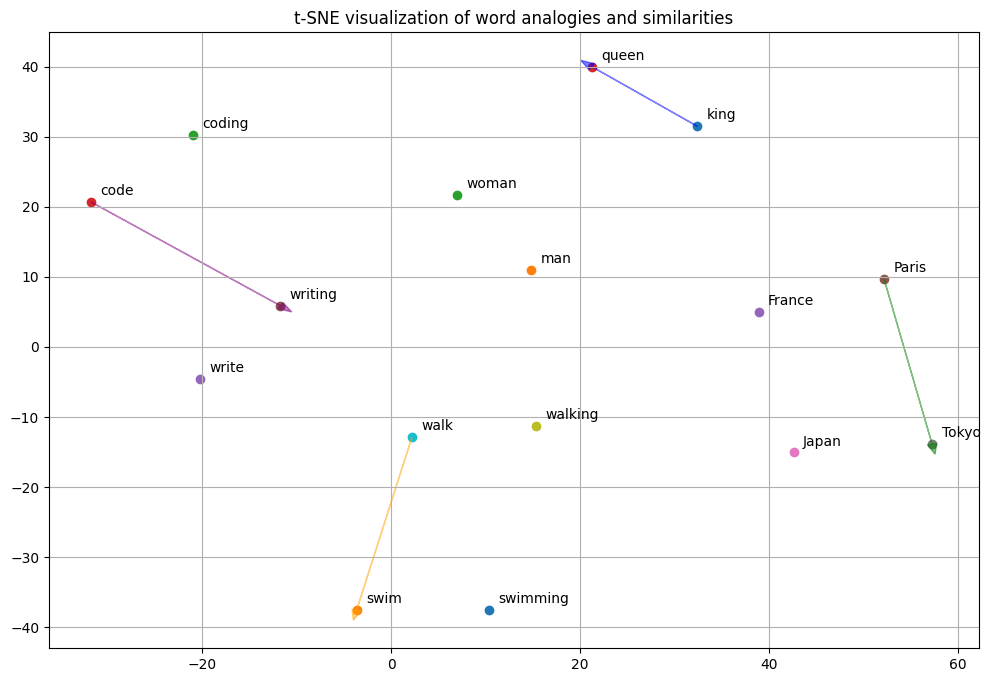

In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Words to visualize
words = [
    'king', 'man', 'woman', 'queen',
    'France', 'Paris', 'Japan', 'Tokyo',
    'walking', 'walk', 'swimming', 'swim',
    'coding', 'code', 'write', 'writing'
]

# Get the vectors
word_vectors = np.array([wv_pretrained[word] for word in words])

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
vectors_2d = tsne.fit_transform(word_vectors)

# Plot
plt.figure(figsize=(12, 8))
for i, word in enumerate(words):
    x, y = vectors_2d[i]
    plt.scatter(x, y)
    plt.annotate(word, (x + 1, y + 1), fontsize=10)

# Helper function to draw analogy arrows
def draw_arrow(from_word, to_word, color='r'):
    i = words.index(from_word)
    j = words.index(to_word)
    x1, y1 = vectors_2d[i]
    x2, y2 = vectors_2d[j]
    plt.arrow(x1, y1, x2 - x1, y2 - y1, color=color, alpha=0.5, head_width=1)

# Draw analogy arrows
draw_arrow('king', 'queen', 'blue')
draw_arrow('Paris', 'Tokyo', 'green')
draw_arrow('walk', 'swim', 'orange')
draw_arrow('code', 'writing', 'purple')

plt.title("t-SNE visualization of word analogies and similarities")
plt.grid(True)
plt.show()


# **Part 2**

mixing text preprocessing, word embeddings (pretrained and custom), and ML model training, all wrapped around sentiment analysis.

1. Load & Explore Dataset (EDA)


In [16]:
import pandas as pd
import kagglehub
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)



# Load dataset
df = pd.read_csv(f"{path}/IMDB Dataset.csv")

# Basic EDA
print(df.head())
print(df['sentiment'].value_counts())

# Add length column
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})




Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


2. Clean the Text

In [18]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # remove HTML
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

df['clean_review'] = df['review'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 3. Vectorization Approaches

We'll vectorize text in 4 different ways.

✅ 3.1 Pretrained Word2Vec (Google News)

In [19]:
from gensim.models import KeyedVectors
import numpy as np
from tqdm import tqdm

# Use already loaded model
w2v_model = wv_pretrained

def get_w2v_vector(text):
    words = text.split()
    word_vecs = [w2v_model[word] for word in words if word in w2v_model]
    if not word_vecs:
        return np.zeros(w2v_model.vector_size)
    return np.mean(word_vecs, axis=0)

X_w2v = np.vstack([get_w2v_vector(text) for text in tqdm(df['clean_review'])])



100%|██████████| 50000/50000 [00:18<00:00, 2647.51it/s]


3.2 Custom Skip-gram Model

In [24]:
from gensim.models import Word2Vec
import numpy as np
from tqdm import tqdm

# Tokenize
tokens = [text.split() for text in df['clean_review']]

# Train Skip-gram
model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=2, sg=1, workers=8)
wv = model.wv
vec_size = wv.vector_size

# Preload all embeddings
emb_matrix = {word: wv[word] for word in wv.key_to_index}
vocab = set(emb_matrix)

# Final matrix preallocated
X_skipgram = np.zeros((len(tokens), vec_size), dtype=np.float32)

# Vectorize FAST
for i, sentence in enumerate(tqdm(tokens, desc="Vectorizing")):
    vecs = [emb_matrix[word] for word in sentence if word in vocab]
    if vecs:
        X_skipgram[i] = np.mean(np.array(vecs), axis=0)


Vectorizing: 100%|██████████| 50000/50000 [00:07<00:00, 6470.77it/s]


3.3 Custom CBOW Model

In [25]:
cbow_model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=2, sg=0, workers=4)

X_cbow = np.vstack([
    np.mean([cbow_model.wv[word] for word in words if word in cbow_model.wv] or [np.zeros(100)], axis=0)
    for words in tokens
])


3.4 Custom FastText Model

In [26]:
from gensim.models import FastText

ft_model = FastText(sentences=tokens, vector_size=100, window=5, min_count=2, workers=4)

X_ft = np.vstack([
    np.mean([ft_model.wv[word] for word in words if word in ft_model.wv] or [np.zeros(100)], axis=0)
    for words in tokens
])


4. Model Training & Evaluation

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(X, y, name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {'Model': name, 'Accuracy': acc, 'F1': f1}

y = df['sentiment'].values

results = []
results.append(evaluate_model(X_w2v, y, 'Pretrained Word2Vec'))
results.append(evaluate_model(X_skipgram, y, 'Custom Skipgram'))
results.append(evaluate_model(X_cbow, y, 'Custom CBOW'))
results.append(evaluate_model(X_ft, y, 'Custom FastText'))

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy        F1
0  Pretrained Word2Vec    0.8510  0.852241
1      Custom Skipgram    0.8750  0.876384
2          Custom CBOW    0.8611  0.863220
3      Custom FastText    0.8465  0.848992


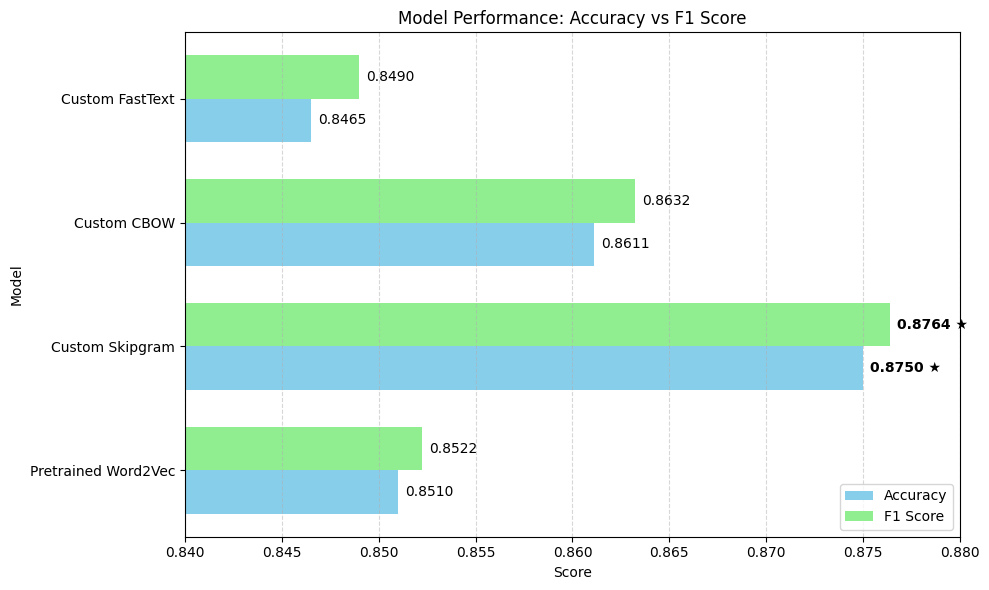

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Pretrained Word2Vec', 'Custom Skipgram', 'Custom CBOW', 'Custom FastText']
accuracy = [0.8510, 0.8750, 0.8611, 0.8465]
f1_score = [0.852241, 0.876384, 0.863220, 0.848992]

x = np.arange(len(models))
width = 0.35

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.barh(x - width/2, accuracy, height=width, label='Accuracy', color='skyblue')
bars2 = ax.barh(x + width/2, f1_score, height=width, label='F1 Score', color='lightgreen')

# Grid, labels, and limits
ax.set_xlabel('Score')
ax.set_ylabel('Model')
ax.set_title('Model Performance: Accuracy vs F1 Score')
ax.set_yticks(x)
ax.set_yticklabels(models)
ax.set_xlim(0.84, 0.88)
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.legend(loc='lower right')

# Highlight top values
def highlight_best(bars):
    max_height = max([bar.get_width() for bar in bars])
    for bar in bars:
        width = bar.get_width()
        label = f'{width:.4f}'
        star = ' ★' if width == max_height else ''
        ax.annotate(label + star,
                    xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(5, 0),
                    textcoords="offset points",
                    va='center', ha='left',
                    fontweight='bold' if star else 'normal')

highlight_best(bars1)
highlight_best(bars2)

plt.tight_layout()
plt.show()
